# [Exp_09] 인물 모드 문제점 찾기

### Step 0 준비.

0. 라이브러리 로드  

In [2]:
import os
import urllib
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

1. 유틸 준비

In [4]:
# semantic segment model 준비.

# model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_dir = '/home/evergrin/python/notebook/data/portrait_mode/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
if not os.path.exists(model_file):
    urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    


In [107]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# print(colormap[:20]) #생성한 20개의 컬러맵 출력

# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
person_color = (128,128,192) # colormap[15]
cat_color = (0,0,64) # colormap[8]


In [83]:
def load_img(img_path):
    img = cv2.imread(img_path)
    
    # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
    segvalues, output = model.segmentAsPascalvoc(img_path)

    #segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
    labels = [LABEL_NAMES[class_id] for class_id in segvalues['class_ids']]
    print("labels:", labels)

    return img, segvalues, output

def draw_img(img, cmap, ax=-1):
    
    if ax == -1:
        ax = plt
    
    if isinstance(cmap, str):
        ax.imshow(img, cmap=cmap)
    else :
        ax.imshow(cv2.cvtColor(img, cmap))
    
    plt.show()
    
def draw_two_imgs(img1, img2, cmap1=cv2.COLOR_BGR2RGB, cmap2=cv2.COLOR_BGR2RGB):
    fig = plt.figure(figsize=(10,35))    
    ax1 = fig.add_subplot(1, 2, 1)
   
    if isinstance(cmap1, str):
        ax1.imshow(img1, cmap=cmap1)
    else :
        ax1.imshow(cv2.cvtColor(img1, cmap1))
    
    ax2 = fig.add_subplot(1, 2, 2)
    if isinstance(cmap2, str):
        ax2.imshow(img2, cmap=cmap2)
    else:
        ax2.imshow(cv2.cvtColor(img2, cmap2))
    plt.show()
    

In [49]:
def segmap_by_color(output, color):
    return np.all(output == color, axis=-1)

def blur_img(img, blr):
    blurred_img = cv2.blur(img, blr)
    return blurred_img

def segmap_to_mask(segmap):
    mask = segmap.astype(np.uint8) * 255
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            val = mask[i][j]
            color_mask[i][j] = np.array([val, val, val])

    return color_mask

def masking_img(img, mask):
    inv_mask = cv2.bitwise_not(mask)
    masked_img = cv2.bitwise_and(img, inv_mask)
    return masked_img



In [104]:
# 인물사진에서 작게 보이는 부분은 멀거나, 중요하지 않은 부분이므로 segment에서 삭제한다.
def remove_small_segments(img, w_ratio=0.2, h_ratio=0.2):
    ary = np.array(img)
    flaten = np.sum(img, axis=2)
    
    # 필터 생성.
    w = int(flaten.shape[0]*w_ratio)
    h = int(flaten.shape[1]*h_ratio)
    filter = np.ones((w, h))
    rects = filter.copy()
    
    # 테두리만 남김.
    rects[1:-1, 1:-1] = 0
    
    for i in range(flaten.shape[0] - w + 1):
        for j in range(flaten.shape[1] - h + 1):
            ckp = flaten[i:i + w, j:j + h]
            ckpsum = np.sum(ckp)
            if ckpsum > 0:
                ck = ckp * rects
                cksum = np.sum(ck)
                if cksum == 0:
                    img[i:i + w, j:j + h] = [0, 0, 0]

    return img



### Step 1. 인물모드 직접 해 보기.   

1. 인물 사진 blur

1/1 [==============================] - 6s 6s/step
labels: ['background', 'chair', 'person']


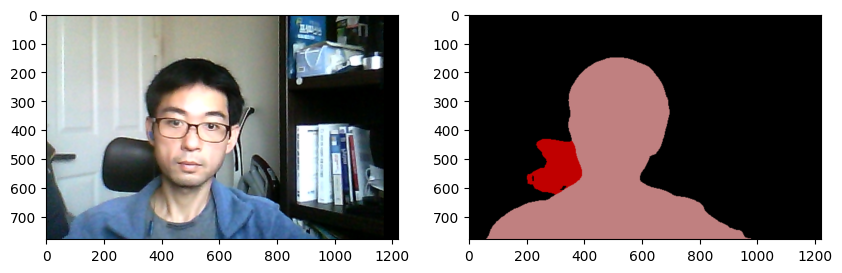

In [84]:
person_img_path = '/home/evergrin/python/notebook/data/portrait_mode/images/myself.png'
person_img, person_segs, person_output = load_img(person_img_path)

# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
person_img_show = person_img.copy()

draw_two_imgs(person_img, person_output)

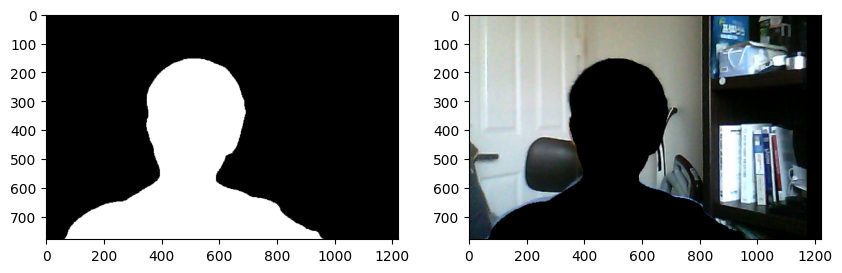

In [85]:
person_segmap = segmap_by_color(person_output, person_color) 

person_mask = segmap_to_mask(person_segmap)

masked_person_img = masking_img(person_img_show, person_mask)
# person_img_show = cv2.addWeighted(person_img_show, 0.6, person_color_mask, 0.4, 0.0)

draw_two_imgs(person_segmap, masked_person_img, 'gray')


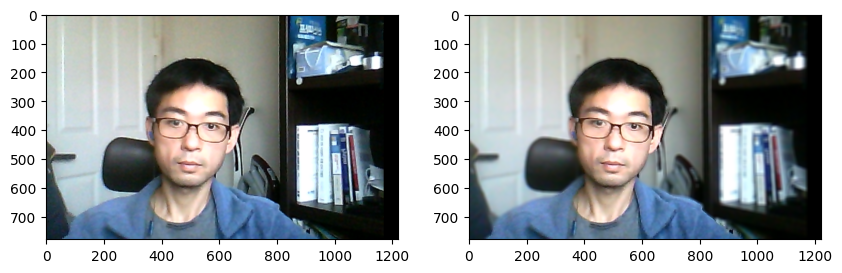

In [99]:
person_img_blur = blur_img(person_img, (13, 13))

person_concat = np.where(person_mask==255, person_img_show, person_img_blur)

draw_two_imgs(person_img, person_concat)

In [109]:
cv2.imwrite('/home/evergrin/python/notebook/data/portrait_mode/images/person_last.png', person_concat)

True

2. 고양이 사진 blur

1/1 [==============================] - 7s 7s/step
labels: ['background', 'cat']


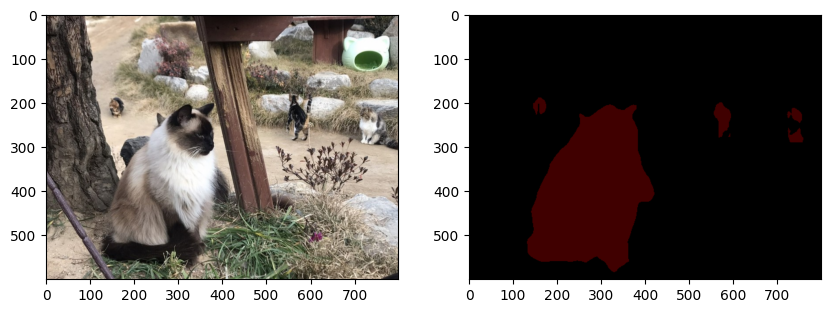

In [116]:
cat_img_path = '/home/evergrin/python/notebook/data/portrait_mode/images/cat2.png'
cat_img, cat_segs, cat_output = load_img(cat_img_path)

# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
cat_img_show = cat_img.copy()

draw_two_imgs(cat_img, cat_output)

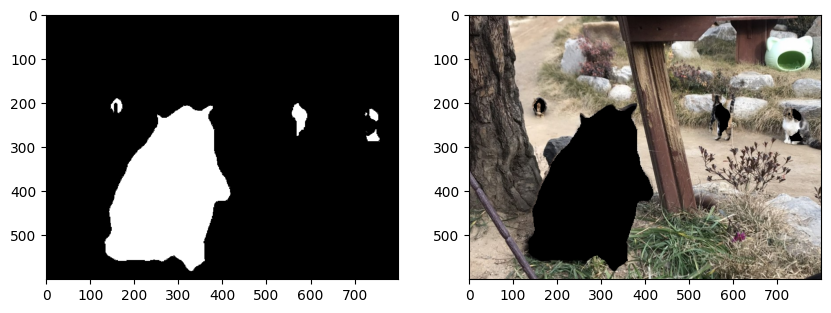

In [117]:
# 인물사진용이므로 멀리있거나, 작은 segment들은 삭제함.
# cat_output = remove_small_segments(cat_output, 0.5, 0.5)

cat_segmap = segmap_by_color(cat_output, cat_color) 

cat_mask = segmap_to_mask(cat_segmap)

masked_cat_img = masking_img(cat_img_show, cat_mask)

draw_two_imgs(cat_segmap, masked_cat_img, 'gray')


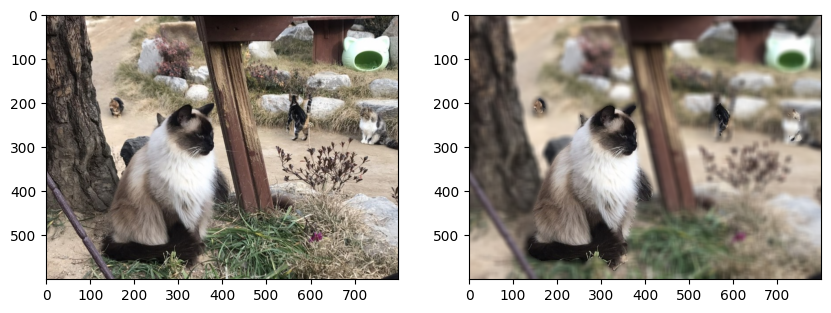

In [118]:
cat_img_blur = blur_img(cat_img, (13, 13))

cat_concat = np.where(cat_mask==255, cat_img_show, cat_img_blur)

draw_two_imgs(cat_img, cat_concat)


In [119]:
cv2.imwrite('/home/evergrin/python/notebook/data/portrait_mode/images/cat_last.png', cat_concat)

True

3. 해변 사진

1/1 [==============================] - 7s 7s/step
labels: ['background', 'person']


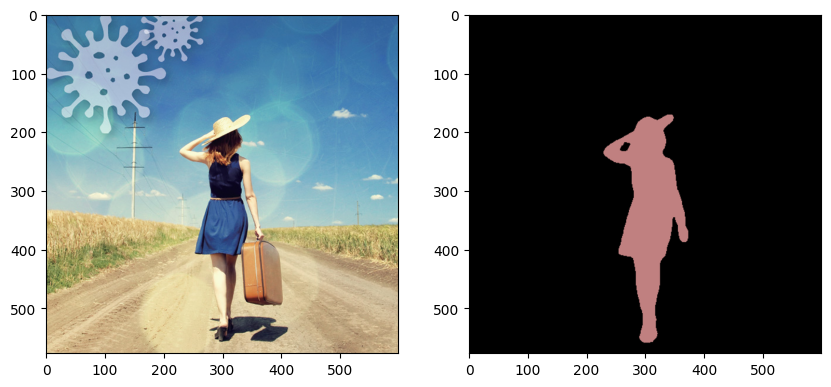

In [102]:
travel_img_path = '/home/evergrin/python/notebook/data/portrait_mode/images/travel.png'
travel_img, travel_segs, travel_output = load_img(travel_img_path)

# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
travel_img_show = travel_img.copy()

draw_two_imgs(travel_img, travel_output)

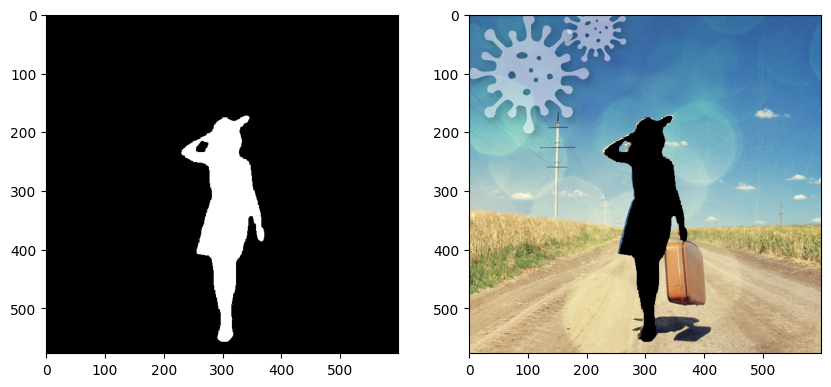

In [105]:
# 인물사진용이므로 멀리있거나, 작은 segment들은 삭제함.
# travel_output = remove_small_segments(travel_output, 0.5, 0.5)

travel_segmap = segmap_by_color(travel_output, person_color) 

travel_mask = segmap_to_mask(travel_segmap)

masked_travel_img = masking_img(travel_img_show, travel_mask)

draw_two_imgs(travel_segmap, masked_travel_img, 'gray')


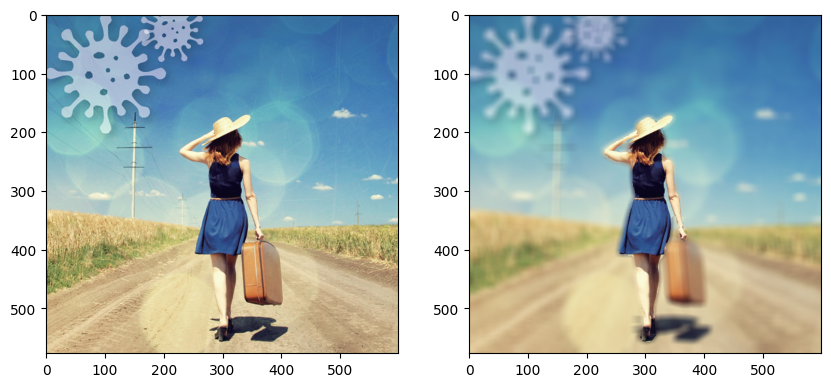

In [106]:
travel_img_blur = blur_img(travel_img, (13, 13))

travel_concat = np.where(travel_mask==255, travel_img_show, travel_img_blur)

draw_two_imgs(travel_img, travel_concat)


In [113]:
cv2.imwrite('/home/evergrin/python/notebook/data/portrait_mode/images/travel_last.png', travel_concat)

True

### Step 2 사진에서 문제점 찾기

0. 블러 처리된 최종 이미지

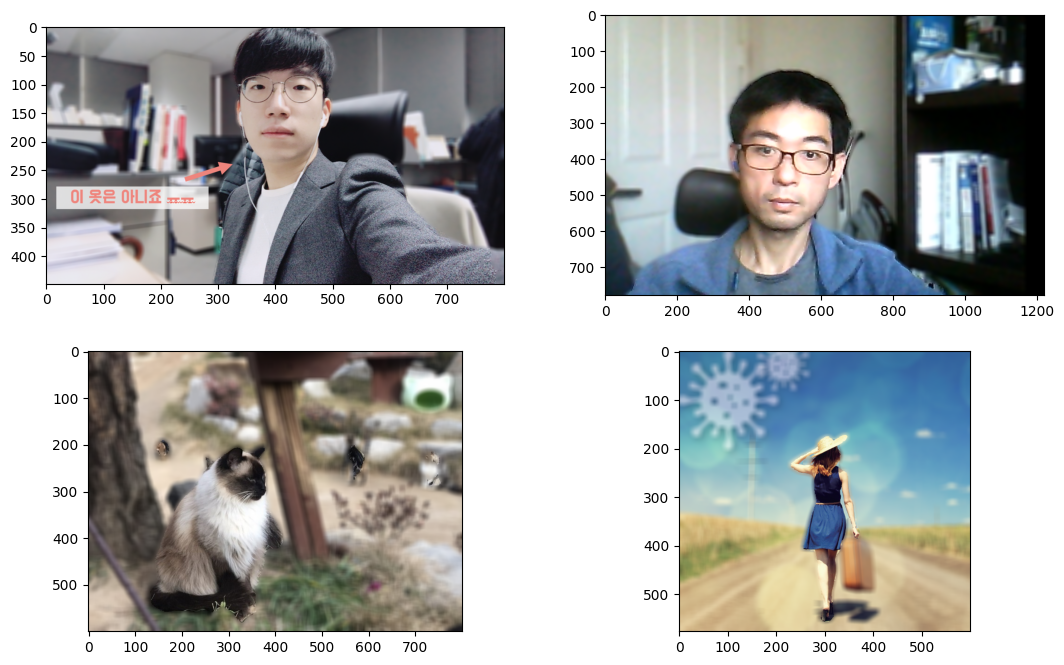

In [124]:
img_path0 = '/home/evergrin/python/notebook/data/portrait_mode/images/sample_last.png'
img_path1 = '/home/evergrin/python/notebook/data/portrait_mode/images/person_last.png'
img_path2 = '/home/evergrin/python/notebook/data/portrait_mode/images/cat_last.png'
img_path3 = '/home/evergrin/python/notebook/data/portrait_mode/images/travel_last.png'

img0 = cv2.imread(img_path0)
img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

fig = plt.figure(figsize=(13,8))    
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    

1. 문제점 확인

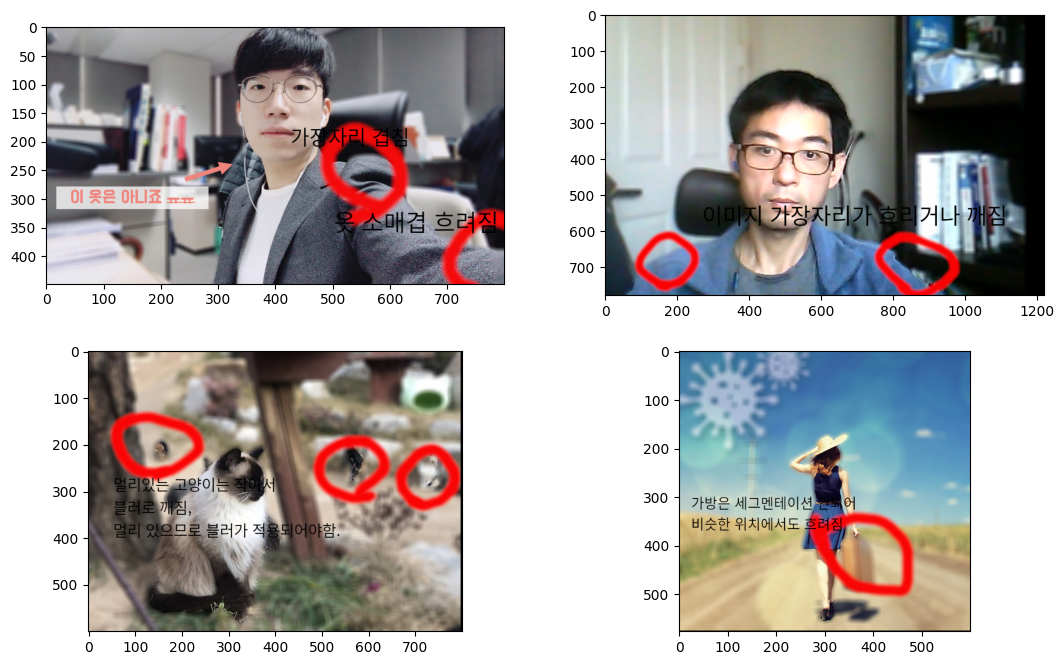

In [126]:
img_path0 = '/home/evergrin/python/notebook/data/portrait_mode/images/sample_last_m.png'
img_path1 = '/home/evergrin/python/notebook/data/portrait_mode/images/person_last_m.png'
img_path2 = '/home/evergrin/python/notebook/data/portrait_mode/images/cat_last_m.png'
img_path3 = '/home/evergrin/python/notebook/data/portrait_mode/images/travel_last_m.png'

img0 = cv2.imread(img_path0)
img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

fig = plt.figure(figsize=(13,8))    
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    

### Step 3. 해결 방법을 제안해 보기



1. 여러개의 작은 세그먼트가 선택된 경우  
 - 인물 사진에서 인물은 일반적으로 크게, 선명하게 표시되므로   
   고양이와 같이 여러개의 세그먼트중, 작거나 중요하지 않은 부분을 아래와 같이 제거하여 블러가 적용되도록 함.  

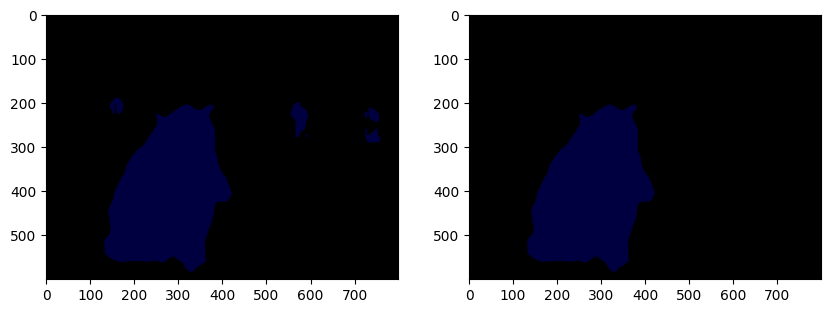

In [130]:
# 작은 segment들은 삭제함.
cat_output_mod = remove_small_segments(cat_output.copy(), 0.3, 0.3)

draw_two_imgs(cat_output, cat_output_mod, 'gray', 'gray')

2. 가장자리의 합성이 깨끗하지 않는 문제.  
 - cv2의 Dilation, Erosion등을 이용하여 mask 가장자리 부분을 조정하는 방법.
 - 이미지 합성할때 세그먼트의 가장자리를 alpha를 적용하여 부드럽게 적용하는 방법 등이 있을것 같습니다.

3. 마지막 이미지에서 가방이 인식되지 않는 문제.  
 - 가방은 세그멘테이션 항목에 없으므로 이를 지원하는 모델을 사용.  
 - 이미지 필터를 이용하여 전처리를 해서 세그멘테이션시 가장자리를 좀더 정확하게 구분하는 방법.  
    - sharp, blur등을 사용하면 세그멘테이션 가장자리가 살짝 변경이 생김을 확인함.

### Step 4 회고

 - 위와 같이 이미지에 대하여 blur를 해보고, 문제점도 찾아보는 시간을 가졌다.   
 - 세그멘테이션을 pre trained모델을 사용함으로써 쉽게 구현할 수 있었으나, 한계점도 있었다.  
 - 실제 이미지 조작을 위해서는 행렬 연산에 대하여 이해가 더 필요했다.  
 - blur, sharp, normalization등은 세그멘테이션에 미세하게 영향을 주었으나 큰 차이는 없었다.